In [142]:
import numpy as np
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')

os.chdir('/home/anovax/open_data/edrsr_data')

os.getcwd()

'/home/anovax/open_data/edrsr_data'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# loading our data

data_with_capitals = pd.read_csv('most_recent/data_with_capitals.csv')
data_full = pd.read_csv('most_recent/data_full.csv')
data_full_reduced = pd.read_csv('most_recent/data_full_bs_reduced.csv')

In [327]:
# before diving into the data and trying to get some new insights, let's try to fit a simple model with a data we have

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# we need a simple function that handle all the process of fitting the data and returning our metric of success
def train_model(data, estimator=None, scaling=True, class_report=True, other=None, score=False, data_splitted=False):
    
    if data_splitted:
        
        X_train, X_test, y_train, y_test = data
        
        model = RandomForestClassifier(150)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(acc)
        print(classification_report(y_test, y_pred))
        
        if score:
            cr = classification_report(y_test, y_pred, output_dict=True)
            return model, acc, cr
        
        return model
        
    else:
        
        if estimator == 'rfc':

            model = RandomForestClassifier(150, random_state=42)
        elif estimator == 'etc':
            model  = ExtraTreesClassifier(150, random_state=42)

        elif estimator == 'logreg':
            model = LogisticRegression()

        elif estimator == 'svc':

            model = SVC(gamma='auto')


        if other != None:
            model = other


        X = data.drop(['outcome'], axis=1).values

        y = data['outcome'].values

        if scaling:
            scaler = StandardScaler()
            X = scaler.fit_transform(X, y)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
    
        print(acc)

        if class_report:
            cr = classification_report(y_test, y_pred)
            print(cr)

        if score:
            cr = classification_report(y_test, y_pred, output_dict=True)
            return model, acc, cr
        else:
            return model

In [236]:
# despite accuracy is belong to 0 and 1 class columns in df, it's not relly on them in reality - it's overall score for both classes

def score_to_frame(score_dict, acc):
    score_frame = pd.DataFrame(cr).drop('support').drop(['micro avg', 'macro avg', 'weighted avg'], axis=1)
    accuracy_frame = pd.DataFrame({'accuracy_total': [acc] * 2}).transpose()
    accuracy_frame.columns = accuracy_frame.columns.astype(float)
    
    score_frame = score_frame.append(accuracy_frame)
    
    return score_frame

In [5]:
# let's try our data with capitals and choose all numeric features
# note: dayofweek - without one hot encoding

features_capitals = ['outcome', 'n_judges', 'n_claimants', 'n_defendants', 'claimant_capital',
       'defendant_capital', 'claimant_as_claimant', 'claimant_as_defendant', 'claimant_overall',
       'defendant_as_claimant', 'defendant_as_defendant', 'defendant_overall',
       'dayofweek', 'duration_days']

capitals_to_train = data_with_capitals.dropna(subset=['n_judges']).copy()

rfc = train_model(capitals_to_train[features_capitals], 'rfc', class_report=False)

0.8028541226215645


### Accuracy is seems to be pretty high, taking into account that it's just a first crash test without any feature selection. Also all our features even have no connection to the decision texts which is supposed to be main indicator of result.

In [64]:
# with larger dataset and all features it's just 72%, much lower than on a smaller dataset with capitals
# why there is such difference in results? We'll get back to this later

features_all = ['outcome', 'n_judges', 'n_claimants', 'n_defendants', 'claimant_as_claimant', 'claimant_as_defendant', 'claimant_overall',
       'defendant_as_claimant', 'defendant_as_defendant', 'defendant_overall',
       'dayofweek', 'duration_days']

full_to_train = data_full.drop('category_code', axis=1).dropna()

rfc = train_model(full_to_train[features_all], 'rfc', class_report=False)

0.715357876441776


In [7]:
# now let's select the larger dataset and just one of our features to see its influence on the model
# let's pick something non-trivial and useless at first sight, for example number of judges

rfc = train_model(full_to_train[['outcome', 'n_judges']], 'rfc', class_report=False)

0.7309211565808185


### What's going on?

Almost 73% and even better than a model with all features included? Really? Just with info about number of judges provided? My guess, the model just learned how to make a good guess based on just proportion of "good" outcomes in our dataset. Now let's try to check it.

In [8]:
# but we have roughly balanced number of positive and negative class, and our model's guess is much better than that

full_to_train.outcome.mean()

0.5872110477334134

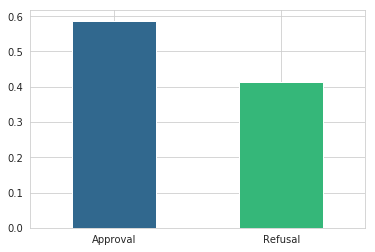

In [9]:
# but let's visualize the same proportion again (we've already done that when comparing the datasets)
with sns.color_palette('viridis', n_colors=2):

    full_to_train.outcome.map({0: 'Refusal', 1: 'Approval'}).value_counts(normalize=True).plot.bar()
    plt.xticks(rotation=0);

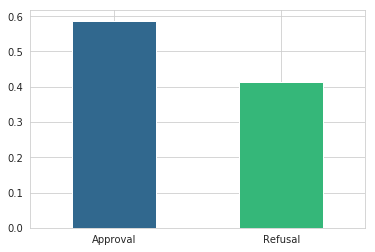

In [13]:
# but let's visualize the same proportion again (we've already done that when comparing the datasets)
with sns.color_palette('viridis', n_colors=2):

    full_to_train.outcome.map({0: 'Refusal', 1: 'Approval'}).value_counts(normalize=True).plot.bar()
    plt.xticks(rotation=0);

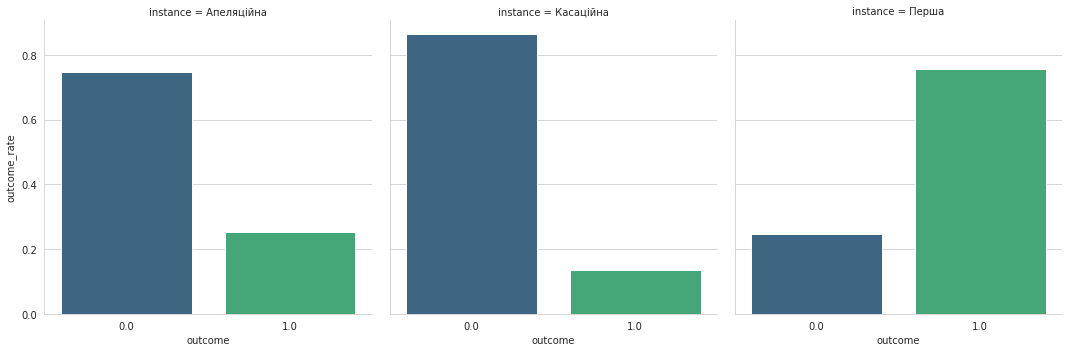

In [69]:
# now let's visualize something more interesting

with sns.color_palette('viridis', n_colors=2):

    group_rates = full_to_train.groupby('instance').outcome.apply(lambda x: x.value_counts(normalize=True))\
                                                            .reset_index().rename({'level_1': 'outcome',
                                                                                   'outcome': 'outcome_rate'}, axis=1)
    sns.catplot(col='instance', x='outcome', y='outcome_rate', data=group_rates, kind='bar');

### Now we see that situation differs a lot if we start being more specific and look into different instances. In 1st, 2nd and 3rd instances there are absolutely different outcome rate. And we see that true proportion for first instance is actually 0.75 and this is far enough from being balanced. Here must come an explanation why accuracy metrics is bad here.

### There are two things that may come to our mind to explain what's going on:
1. Maybe our model always just trying to get a best guess by knowing the proportion in the first instance only. The first instance is probably the most frequent case, and some amounts of 2nd and 3rd instances can't have huge impact on our score (even while they have different proportion). 
2. Our model learned how to separate instances and making its guess instance-wise.

Actually we can easily check that.

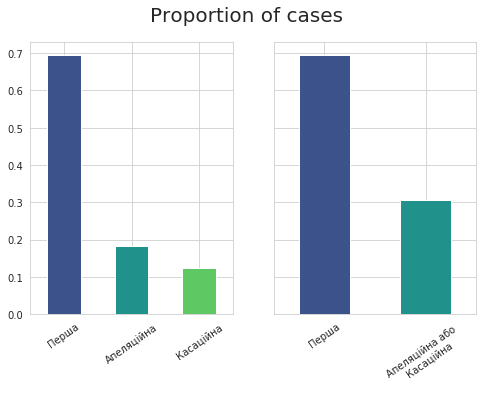

In [45]:
# first, we need to see how many samples of each instance we have
# so we have enough 2nd and 3rd instance sample to lower our accuracy score much stronger than we can observe

with sns.color_palette('viridis', n_colors=3):

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 5))

    full_to_train.instance.value_counts(normalize=True).plot.bar(ax=ax[0]);
    full_to_train.instance.map({'Перша': 'Перша',
                                    'Апеляційна': 'Апеляційна або \nКасаційна', 
                                    'Касаційна': 'Апеляційна або \nКасаційна'}).value_counts(normalize=True).plot.bar(ax=ax[1]);

    for a in ax:
        a.set_xticklabels(a.get_xticklabels(), rotation=35)

    fig.suptitle('Proportion of cases', size=20);
    fig.savefig('proportion_of_cases.png')

In [358]:
# also we can pick other even more useless feature, for example document length and to see if there's any difference
# we're guessing much better than this with n_judges feature, so probably model has learned how to split instances
# but this is good example of the model not much better than random guess

rfc = train_model(full_to_train[['outcome', 'length']], 'rfc', class_report=False)

0.5331805972507505


In [73]:
# and how can we explicitly check that model giving predictions just based on proportion?
# well, let's try to fit our model instance-wise

scores = []
instances = ["Перша", "Апеляційна", "Касаційна"]

for i in instances:
    data = full_to_train.query("instance == @i")
    
   
    _, accuracy, _ = train_model(data[['outcome', 'n_judges']], 'rfc', class_report=False, score=True)
    
    scores.append(round(accuracy, 2))
    
scores_df = pd.DataFrame({'instance': instances, 'score': scores})

0.756061468412066
0.7468682505399568
0.8736369467607441


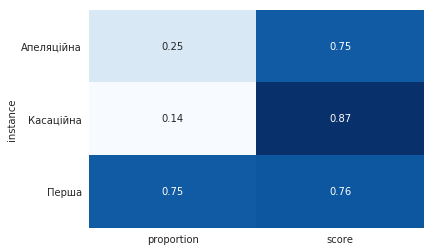

In [79]:
# almost perfect match, note that proportion 25% means that there are 25% of postitives and 75% of negatives
# so to predict based on the proportion we can predict 75% of negatives all the time and be 75%% accurate

prop_df = full_to_train.groupby('instance').outcome.mean().apply(round, ndigits=2).reset_index()\
                                                                            .rename({'outcome': 'proportion'},axis=1)

merged = pd.merge(prop_df, scores_df)

merged.set_index('instance', inplace=True)

sns.heatmap(merged, annot=True, cbar=False, cmap='Blues')
plt.yticks(rotation=0);

### Thus, we can tell that our model learned how to split instance based on number of judges in a trial. Now let's get trusted score of our model.

In [361]:
# we see that recall on negative class is far from being perfect

rfc = train_model(full_to_train[['outcome', 'n_judges']], 'rfc')

0.7309211565808185
              precision    recall  f1-score   support

         0.0       0.69      0.62      0.65      5191
         1.0       0.75      0.81      0.78      7467

   micro avg       0.73      0.73      0.73     12658
   macro avg       0.72      0.71      0.72     12658
weighted avg       0.73      0.73      0.73     12658



# Explanatory Data Analysis

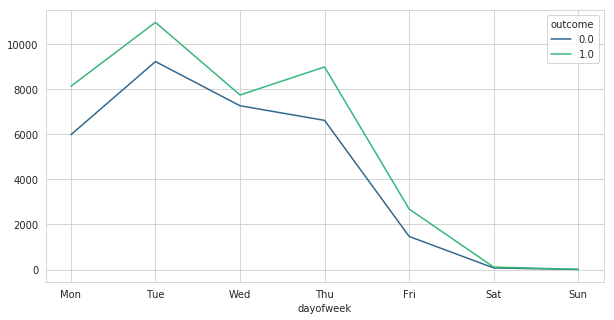

In [88]:
with sns.color_palette('viridis', n_colors=2):

    # let's look closer to day of week patterns
    
    fig, ax = plt.subplots(figsize=(10, 5))

    unstacked = data_full.groupby(['dayofweek', 'outcome']).size().unstack().reset_index()
    
    melted = pd.melt(unstacked, 'dayofweek') # left one key as group indicator

    unstacked.plot('dayofweek', ax=ax); # the number of cases slowly goind down to the end of the week
    ax.set_xticks(ticks=range(7))
    ax.set_xticklabels(labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

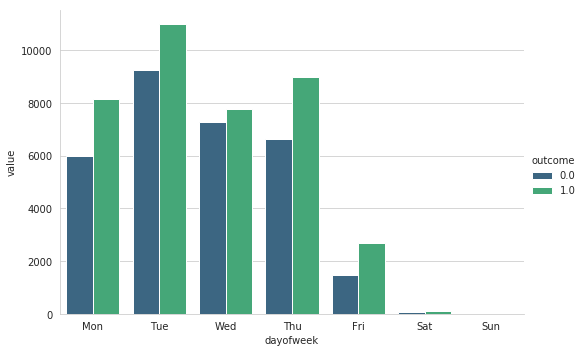

In [102]:
# what about chance to get positive or negative decision?

sns.catplot(x='dayofweek', y='value', hue='outcome', data=melted, kind='bar', palette='viridis', aspect=1.5)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);

In [105]:
# now let's be more specific and check tendency of judge to particular day
# first we select top 10 judges that has enough cases to look for some pattern

largest_10 = data_full.groupby('judge').size().nlargest(10).index.tolist()

df_top_10 = data_full.loc[data_full.judge.isin(largest_10)]

unstacked = df_top_10.groupby(['judge', 'dayofweek', 'outcome']).size().unstack().reset_index()

unstacked.columns.name = None

unstacked.fillna(0, inplace=True)

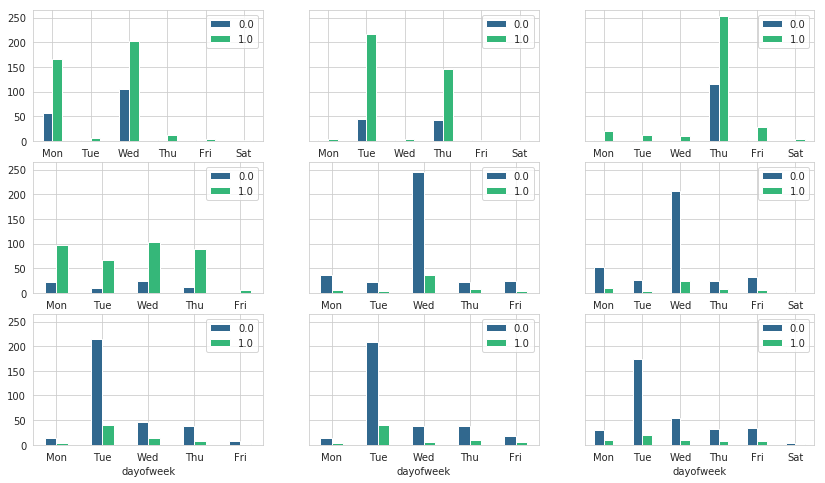

In [66]:
# first - much clearer than day of week pattern we see general pattern of approval/refusal rate
# second - judges definitely have some schedule and usually top 1 or 2 working days for decisions, probably rest - for other routine

with sns.color_palette('viridis', n_colors=2):

    fig, axes = plt.subplots(3, 3, figsize=(14, 8), sharey=True)

    for judge, ax in zip(largest_10, axes.flat):

        unstacked[unstacked.judge == judge].plot.bar('dayofweek', ax=ax);
        ax.set_xticklabels(labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
        
    fig.subplots_adjust(hspace=0.16)

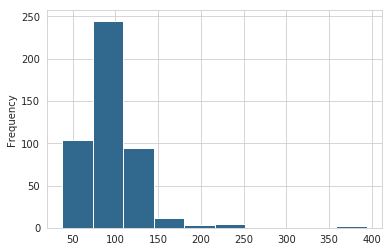

In [61]:
# now let's check if there are some judges that often consider cases longer than usual

with sns.color_palette('viridis', n_colors=2):

    grouped = data_full.groupby('judge').size()

    more_50 = grouped[grouped > 50].index.tolist()

    df_50 = data_full[data_full.judge.isin(more_50)]

    df_50.groupby('judge')['duration_days'].median().plot.hist();

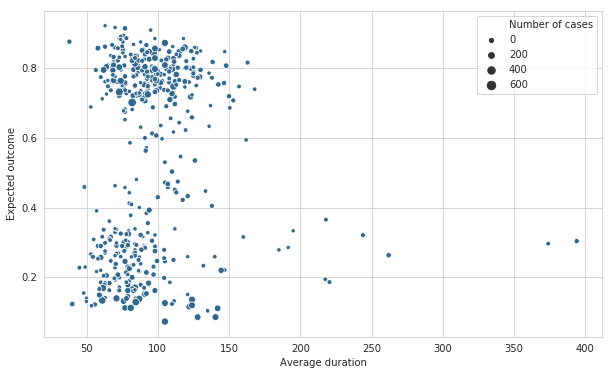

In [131]:
# judges that usually consider cases longer, more often refuse

averages = df_50.groupby('judge').aggregate({'duration_days': 'median', 
                                     'outcome': 'mean', 'cause_num': 'count'}).reset_index(drop=True)\
                                     .rename({'duration_days': 'Average duration',
                                             'outcome': 'Expected outcome',
                                             'cause_num': 'Number of cases'}, axis=1)

with sns.color_palette('viridis', n_colors=2):
    
    plt.figure(figsize=(10, 6))

    sns.scatterplot('Average duration', 'Expected outcome', data=averages, size='Number of cases')

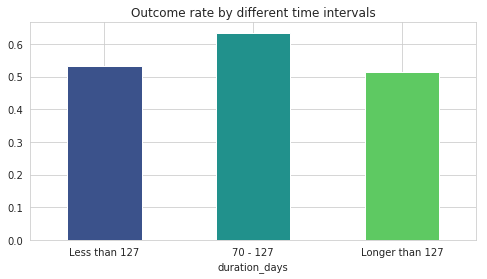

In [134]:
# in general it doesn't look that longer duration is always means higher risk to get refusal
# but we see the middle has higher 

with sns.color_palette('viridis', n_colors=3):
    
    plt.figure(figsize=(8, 4))
    duration_quantiles = pd.qcut(df_50.duration_days, 3, ['Less than 127', '70 - 127', 'Longer than 127'])

    df_50.groupby(duration_quantiles).outcome.mean().plot.bar();
    
    
    plt.xticks(rotation=0)
    plt.title('Outcome rate by different time intervals');

In [136]:
# what about anomalous long cases?
from sklearn.preprocessing import scale

# let's look into 3 std above the mean
df_50[scale(df_50.duration_days) > 3].outcome.mean()

0.349833147942158

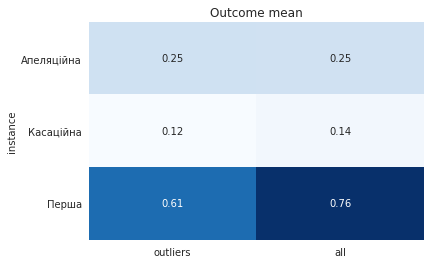

In [441]:
# as usual let's try to be more specific
# now we can see that pattern holds only for a first instance cases

outliers_mean = df_50[scale(df_50.duration_days) > 3].groupby('instance').outcome.mean()

common_mean = df_50.groupby('instance').outcome.mean()

sns.heatmap(pd.DataFrame({'outliers': outliers_mean, 'all': common_mean}), annot=True, cbar=False, cmap='Blues');

plt.yticks(rotation=0)
plt.title('Outcome mean');

In [459]:
# now let's take random judge and look for duration pattern individually
# for this particular judge the longer duration, higher success rate

rand_judge = df_50[df_50.judge == df_50.judge.sample(1, random_state=42).iloc[0]][['duration_days', 'outcome']]

rand_judge['quantiles'] = rand_judge.duration_days.transform(pd.qcut, q=3)

rand_judge.groupby('quantiles').outcome.mean() 

quantiles
(24.999, 83.333]    0.672131
(83.333, 118.0]     0.721311
(118.0, 762.0]      0.866667
Name: outcome, dtype: float64

In [460]:
# and absolutely different pattern for another judge
# the main point that patterns differ

rand_judge = df_50[df_50.judge == df_50.judge.sample(1, random_state=101).iloc[0]][['duration_days', 'outcome']]

rand_judge['quantiles'] = rand_judge.duration_days.transform(pd.qcut, q=3)

rand_judge.groupby('quantiles').outcome.mean()

quantiles
(28.999, 64.0]     0.956522
(64.0, 88.333]     0.578947
(88.333, 795.0]    0.476190
Name: outcome, dtype: float64

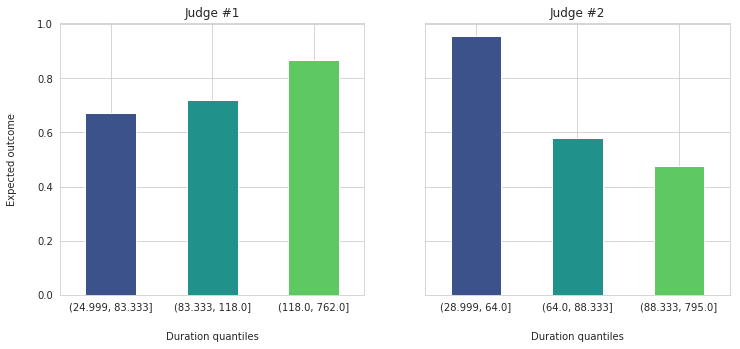

In [160]:
with sns.color_palette('viridis', n_colors=3):
    
    fix, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

    for idx, rs  in enumerate([42, 101]):

        rand_judge = df_50[df_50.judge == df_50.judge.sample(1, random_state=rs).iloc[0]][['duration_days', 'outcome']]

        rand_judge['Duration quantiles'] = rand_judge.duration_days.transform(pd.qcut, q=3)

        rand_judge.groupby('Duration quantiles').outcome.mean().plot.bar(ax=ax[idx]);

        ax[idx].set_title(f'Judge #{idx+1}')
        
        ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=0)
        
        ax[idx].set_xlabel('Duration quantiles', labelpad=20)
        ax[idx].set_ylabel('Expected outcome', labelpad=20)

In [526]:
# now let's try to visualize those patterns for 9 random judges 

# judges_samples = df_50.judge.sample(9, random_state=12).tolist()

# df_to_concat = []

# for idx, judge in enumerate(judges_samples, start=1):
    
#     rand_judge = df_50[df_50.judge == judge][['duration_days', 'outcome']]
    
#     rand_judge['quantiles'] = rand_judge.duration_days.transform(pd.qcut, q=3, labels=['Short', 'Middle', 'Long'])

#     outcome_means = rand_judge.groupby('quantiles').outcome.mean().reset_index()
    
#     outcome_means['judge'] = f'j #{idx}'
    
#     df_to_concat.append(outcome_means)

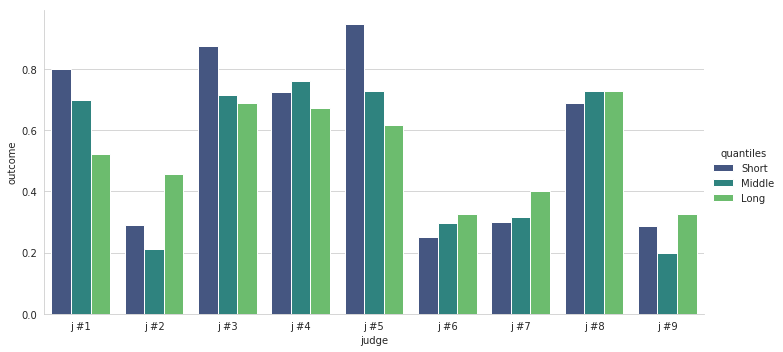

In [527]:
# accum_df = pd.concat(df_to_concat)

# sns.catplot(x='judge', y='outcome', hue='quantiles', data=accum_df, kind='bar', palette='viridis', aspect=2);

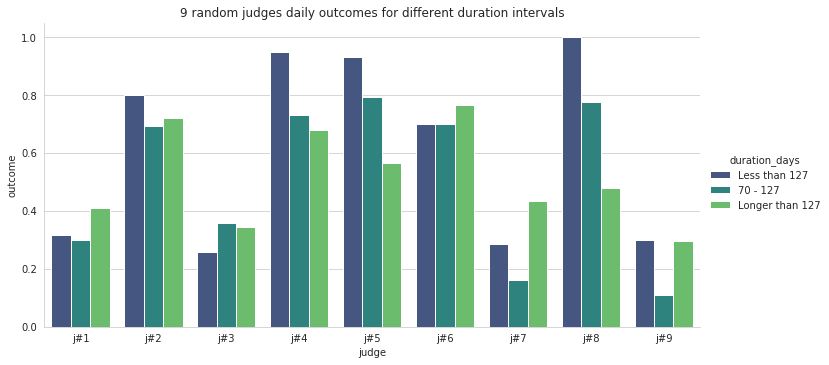

In [139]:
# now let's try to visualize those patterns for 9 random judges
# actually here we're not considering judges individual quantiles, but quantiles common for all dataset

judges_samples = df_50.judge.sample(9, random_state=12).tolist()

aggr_means = df_50.groupby(['judge', duration_quantiles]).outcome.mean().reset_index()

selected_df = aggr_means[aggr_means.judge.isin(judges_samples)].copy()

mapping_dict = dict(zip(selected_df.judge.unique(), 
         ['j#'+ str(i+1) for i in range(10)]))

selected_df['judge'] = selected_df.judge.map(mapping_dict)

sns.catplot(x='judge', y='outcome', hue='duration_days', data=selected_df, kind='bar', palette='viridis', aspect=2);
plt.title('9 random judges daily outcomes for different duration intervals');

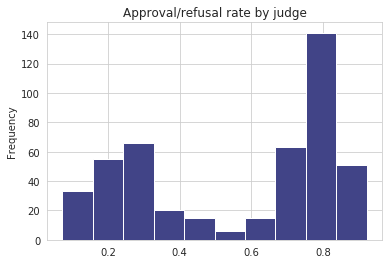

In [77]:
# outcome rate histogram by judge is very diverse
# thus it's a good reason to get those rate for each particular judge as parameter

with sns.color_palette('viridis', n_colors=4):

    df_50.groupby('judge')['outcome'].mean().plot.hist()

    plt.title('Approval/refusal rate by judge');

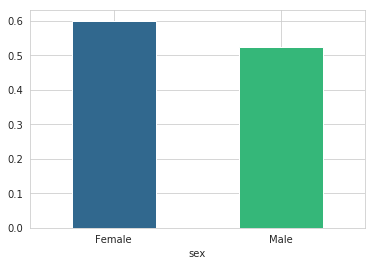

In [60]:
# no difference for sex
with sns.color_palette('viridis', n_colors=2):
    data_full_reduced['sex'] = data_full_reduced.bin_sex.map({0: 'Male', 1: 'Female'})
    data_full_reduced.groupby(['sex']).outcome.mean().plot.bar()
    plt.xticks(rotation=0);

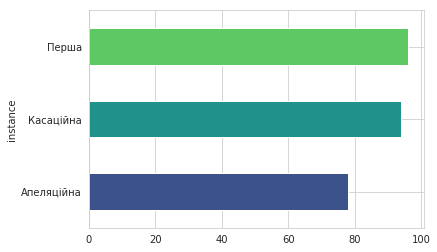

In [61]:
# median duration by instances
# not mean because a lot of outliers

with sns.color_palette('viridis', n_colors=3):
    df_50.groupby(['instance']).duration_days.median().plot.barh();

In [62]:
# what about our claimant/defendant features?
# note the difference in datasets, in full dataset difference between 1's and the rest is a lot bigger, which is reasonable
# the difference is probably because a lot of that parties didn't extracted very well, so didn't match anywhere else

grouped_full = data_full.groupby('claimant_overall').size().nlargest(4)
grouped_capitals = data_with_capitals.groupby('claimant_overall').size().nlargest(4)

joined_data = pd.concat([grouped_full, grouped_capitals], axis=1, keys=['full', 'capitals'])

melted = pd.melt(joined_data.reset_index(), 'claimant_overall', var_name='dataset', value_name='size')

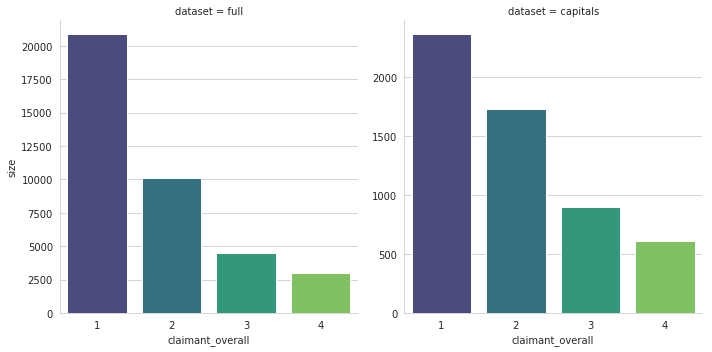

In [63]:
sns.catplot(col='dataset', x='claimant_overall', y='size', kind='bar', data=melted, sharey=False, palette='viridis');

## Inspecting time data

In [143]:
date_times = pd.read_csv('date_times_uhvala.csv')
decisions_uhvala = pd.read_csv('decision_uhvala_v2.csv')

date_times.dropna(subset=['date_times'], inplace=True)

times = pd.merge(decisions_uhvala, date_times, left_on='uhvala_id', right_on='id')
times.drop_duplicates(subset='dec_id', inplace=True)

df_times = pd.merge(data_full, times[['dec_id', 'date_times']], left_on='id', right_on='dec_id')
df_times.dropna(subset=['date_times'], inplace=True)
df_times['date_times'] = df_times.date_times.apply(ast.literal_eval)

df_capitals_times = pd.merge(data_with_capitals, times[['dec_id', 'date_times']], left_on='id', right_on='dec_id')
df_capitals_times.dropna(subset=['date_times'], inplace=True)
df_capitals_times['date_times'] = df_capitals_times.date_times.apply(ast.literal_eval)

In [144]:
# DON'T FORGET that value of everything except time is just a placeholder

def clean_time(row):
    """Clears values with errors"""
    try:
        return pd.to_datetime(row[1])
    except ValueError:
#         print(row)
        return None

df_times['time'] = df_times.date_times.apply(clean_time)
df_capitals_times['time'] = df_capitals_times.date_times.apply(clean_time)

In [145]:
df_times = df_times[(df_times.time < '18:00') & (df_times.time > '09:00')]
df_capitals_times = df_capitals_times[(df_capitals_times.time < '18:00') & (df_capitals_times.time > '09:00')]

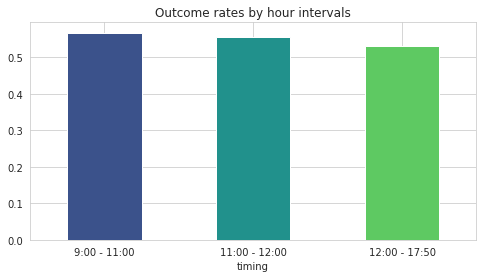

In [146]:
# looks like there are no time pattern

with sns.color_palette('viridis', n_colors=3):
    
    plt.figure(figsize=(8, 4))

    df_times['timing'] = pd.qcut(df_times.time, 3, labels=['9:00 - 11:00', '11:00 - 12:00', '12:00 - 17:50']) # changed to range categories
    df_capitals_times['timing'] = pd.qcut(df_capitals_times.time, 3, labels=['9:00 - 11:00', '11:00 - 12:30', '12:30 - 17:45'])


    df_times.groupby('timing')['outcome'].mean().plot.bar();
    plt.xticks(rotation=0);
    plt.title('Outcome rates by hour intervals');

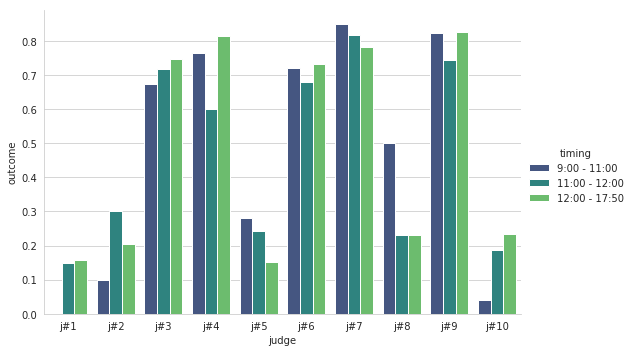

In [32]:
# patterns are very different and not clear if it's really usefull information
# no suprise that in general there is no difference

times_50 = df_times[df_times.judge.isin(more_50)]

grouped_10 = times_50[times_50.judge.isin(times_50.judge.sample(10, random_state=101).tolist())]\
                                        .groupby(['judge', 'timing'])['outcome'].mean().reset_index()

mapping_dict = dict(zip(grouped_10.judge.unique(), 
         ['j#'+ str(i+1) for i in range(10)]))

grouped_10['judge'] = grouped_10.judge.map(mapping_dict)

sns.catplot(x='judge', y='outcome', hue='timing', data=grouped_10, kind='bar', aspect=1.5, palette='viridis');

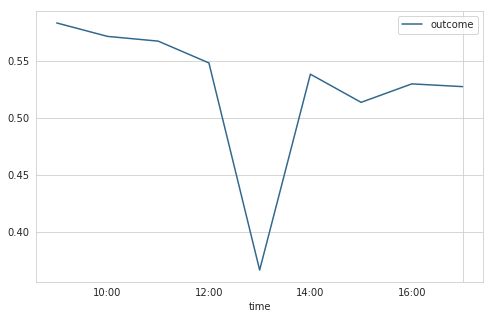

In [154]:
# gap in 13:00 at lunch
with sns.color_palette('viridis', n_colors=2):
    
    fig, ax = plt.subplots(figsize=(8, 5))

    df_times[['time', 'outcome']].set_index('time').resample('H').mean().dropna().plot(ax=ax);

In [91]:
lunch_separator = pd.cut(times_50.time, pd.to_datetime(['09:00', '13:00', '18:00']), 
                         labels=['Before lunch', 'After lunch'])

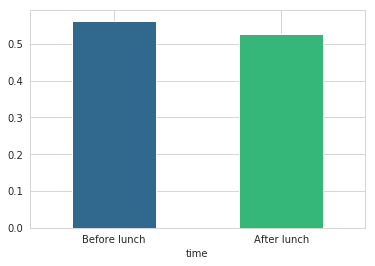

In [92]:
# no pattern
with sns.color_palette('viridis', n_colors=2):
    
    times_50.groupby(lunch_separator).outcome.mean().plot.bar();
    plt.xticks(rotation=0);

In [34]:
# now after we've done some analysis let's try to get more features

df_capitals_times['judge_average_duration'] = df_capitals_times.groupby('judge')['duration_days'].transform('median')

df_capitals_times['judge_expected_outcome'] = df_capitals_times.groupby('judge')['outcome'].transform('mean')

df_capitals_times['hour'] = df_capitals_times['time'].apply(lambda x: x.hour)
df_capitals_times['minute'] = df_capitals_times['time'].apply(lambda x: x.minute)

In [95]:
# after merging with times there are only 7239 left

df_capitals_times.shape

(7239, 40)

In [35]:
features_selected = ['outcome', 'n_judges', 'n_claimants', 'n_defendants', 'claimant_capital',
       'defendant_capital', 'claimant_as_claimant', 'claimant_as_defendant', 'claimant_overall',
       'defendant_as_claimant', 'defendant_as_defendant', 'defendant_overall',
       'dayofweek', 'duration_days']

In [36]:
# so let's train our model with initial features

rfc = train_model(df_capitals_times[features_capitals].dropna(), 'rfc')

0.7984313725490196
              precision    recall  f1-score   support

         0.0       0.78      0.72      0.75       530
         1.0       0.81      0.85      0.83       745

   micro avg       0.80      0.80      0.80      1275
   macro avg       0.79      0.79      0.79      1275
weighted avg       0.80      0.80      0.80      1275



In [37]:
# now let's try to add some new features 

next_features = features_capitals + ['judge_average_duration', 'judge_expected_outcome', 'hour', 'minute']

rfc = train_model(df_capitals_times[next_features].dropna(), 'rfc')

0.8368627450980393
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       530
         1.0       0.84      0.88      0.86       745

   micro avg       0.84      0.84      0.84      1275
   macro avg       0.83      0.83      0.83      1275
weighted avg       0.84      0.84      0.84      1275



In [38]:
# also removing n_judges - we want our model to find more common patterns and n_judges null val reduce our dataset a lot
# and we get overall score lower, but more recall on negative class which is important

next_features = [f for f in features_capitals if f != 'n_judges'] + ['judge_average_duration', 
                                                                     'judge_expected_outcome', 'hour', 'minute']

rfc = train_model(df_capitals_times[next_features], 'rfc')

0.8232044198895028
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       647
         1.0       0.84      0.84      0.84       801

   micro avg       0.82      0.82      0.82      1448
   macro avg       0.82      0.82      0.82      1448
weighted avg       0.82      0.82      0.82      1448



In [39]:
# adding mean outcome for different time interval only making the situation worse
# maybe it's just confuses with expected_outcome for each judge, which is more stable
# also it's a bad feature for judges with a small number of cases, who doesn't even have some of the intervals at all

df_timing = pd.merge(df_capitals_times, df_capitals_times.groupby(['judge', 'timing']).outcome.mean().unstack().fillna(0),
                                            left_on='judge', right_index=True)

next_features = [f for f in features_capitals if f != 'n_judges'] + ['judge_average_duration', 
                                                                     'judge_expected_outcome', 
                                                                     '9:00 - 11:00', '11:00 - 12:30', '12:30 - 17:45']

rfc = train_model(df_timing[next_features], 'rfc')

0.8066298342541437
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       667
         1.0       0.81      0.84      0.82       781

   micro avg       0.81      0.81      0.81      1448
   macro avg       0.81      0.80      0.80      1448
weighted avg       0.81      0.81      0.81      1448



In [40]:
# there are a lot of different ways to fit the time data to a model and some of them I've already tried, it didn't help
# and without timing features it's actually higher

next_features = [f for f in features_capitals if f != 'n_judges'] + ['judge_average_duration', 
                                                                     'judge_expected_outcome']

rfc = train_model(df_capitals_times[next_features], 'rfc')

0.830110497237569
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       647
         1.0       0.85      0.85      0.85       801

   micro avg       0.83      0.83      0.83      1448
   macro avg       0.83      0.83      0.83      1448
weighted avg       0.83      0.83      0.83      1448



## Training warm-up

In [155]:
features_capitals = ['outcome', 'n_judges', 'n_claimants', 'n_defendants', 'claimant_capital',
       'defendant_capital', 'claimant_as_claimant', 'claimant_as_defendant', 'claimant_overall',
       'defendant_as_claimant', 'defendant_as_defendant', 'defendant_overall',
       'dayofweek', 'duration_days']

features_all = ['outcome', 'n_judges', 'n_claimants', 'n_defendants', 'claimant_as_claimant', 'claimant_as_defendant', 'claimant_overall',
       'defendant_as_claimant', 'defendant_as_defendant', 'defendant_overall',
       'dayofweek', 'duration_days']

In [156]:
# raw sample, no n_judges, no capitals, but reduced dataset

next_features = [f for f in features_all if f != 'n_judges']

rfc, acc, cr = train_model(data_with_capitals[next_features], 'rfc', score=True)

0.6559808612440191
              precision    recall  f1-score   support

         0.0       0.61      0.55      0.58       901
         1.0       0.68      0.74      0.71      1189

   micro avg       0.66      0.66      0.66      2090
   macro avg       0.65      0.64      0.64      2090
weighted avg       0.65      0.66      0.65      2090



In [300]:
def compare_two_scores(scores_list, names=None):

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    cbar_ax = fig.add_axes([1.05, 0.05, 0.01, 0.8])

    for idx, ax in enumerate(axes):
        sns.heatmap(scores_list[idx], annot=True, cmap='YlGnBu', ax=ax, cbar=idx==0,
                   cbar_ax=None if idx else cbar_ax);
        
        if names:
            ax.set_title(f'Dataset: {names[idx]}', pad=30)
            
            
        ax.tick_params(axis=u'both', which=u'both',length=0)
        ax.set_xticklabels(['Class 0', 'Class 1'])
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.xaxis.tick_top();

    fig.tight_layout()

In [182]:
# capitals, but no n_judges

next_features = [f for f in features_capitals if f != 'n_judges']

rfc = train_model(data_with_capitals[next_features], 'rfc')

0.7062200956937799
              precision    recall  f1-score   support

         0.0       0.68      0.61      0.64       901
         1.0       0.72      0.78      0.75      1189

   micro avg       0.71      0.71      0.71      2090
   macro avg       0.70      0.69      0.70      2090
weighted avg       0.70      0.71      0.70      2090



In [183]:
# no capitals, but n_judges exists

rfc = train_model(data_with_capitals[features_all].dropna(), 'rfc')

0.7595137420718816
              precision    recall  f1-score   support

         0.0       0.69      0.68      0.69       730
         1.0       0.80      0.81      0.81      1162

   micro avg       0.76      0.76      0.76      1892
   macro avg       0.75      0.74      0.75      1892
weighted avg       0.76      0.76      0.76      1892



In [287]:
# both n_judges and capitals

rfc, acc, cr = train_model(data_with_capitals[features_capitals].dropna(), 'rfc', score=True)

0.8028541226215645
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74       730
         1.0       0.83      0.85      0.84      1162

   micro avg       0.80      0.80      0.80      1892
   macro avg       0.79      0.79      0.79      1892
weighted avg       0.80      0.80      0.80      1892



In [288]:
# init empty dict to store scores

iterations_and_scores = {}

# saving for further use

metrics_df = score_to_frame(cr, acc)

iterations_and_scores['Capitals with n_judges'] = metrics_df

## Trying to filter out  samples with judges that has low number of cases

In [289]:
# first let's recall the score with init size dataset with n_judges
# with our new averages, but also with n_judges, we see that overall score increases, but recall on negative class lowers

data_with_capitals['judge_average_duration'] = data_with_capitals.groupby('judge')['duration_days'].transform('median')

data_with_capitals['judge_expected_outcome'] = data_with_capitals.groupby('judge')['outcome'].transform('mean')

next_features = features_capitals+ ['judge_average_duration', 'judge_expected_outcome']

rfc, acc, cr = train_model(data_with_capitals[next_features].dropna(), 'rfc', score=True)

# saving for further use
metrics_df = score_to_frame(cr, acc)
iterations_and_scores['Capitals with n_judges + aggr_features'] = metrics_df

0.8403805496828752
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79       730
         1.0       0.86      0.89      0.87      1162

   micro avg       0.84      0.84      0.84      1892
   macro avg       0.83      0.83      0.83      1892
weighted avg       0.84      0.84      0.84      1892



In [291]:
# without n_judges

next_features = [f for f in features_capitals if f != 'n_judges'] + ['judge_average_duration', 
                                                                     'judge_expected_outcome']

rfc, acc, cr = train_model(data_with_capitals[next_features], 'rfc', score=True)

# saving for further use
metrics_df = score_to_frame(cr, acc)
iterations_and_scores['Capitals aggr_features, NO n_judges'] = metrics_df

0.8282296650717703
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       901
         1.0       0.85      0.85      0.85      1189

   micro avg       0.83      0.83      0.83      2090
   macro avg       0.83      0.82      0.82      2090
weighted avg       0.83      0.83      0.83      2090



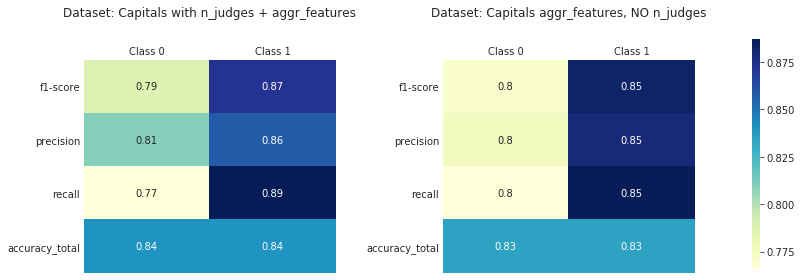

In [301]:
# comparing two scores

compare_two_scores([iterations_and_scores['Capitals with n_judges + aggr_features'],
                  iterations_and_scores['Capitals aggr_features, NO n_judges']],
                   names=['Capitals with n_judges + aggr_features', 'Capitals aggr_features, NO n_judges'])

In [302]:
# let's try to remove judges with cases less than 15 and see how that influence a score
# 15 treshold will reduce our dataset to 8861, which is at least acceptable

grouped = data_with_capitals.groupby('judge').size()

more_15 = grouped[grouped > 15].index.tolist()

df_15 = data_with_capitals[data_with_capitals.judge.isin(more_15)]

df_15.shape

(8861, 34)

In [303]:
# and it really improves a score by 2%

next_features = [f for f in features_capitals if f != 'n_judges'] + ['judge_average_duration', 
                                                                     'judge_expected_outcome']

rfc, acc, cr = train_model(df_15[next_features], 'rfc', score=True)

# saving metrics
metrics_df = score_to_frame(cr, acc)
iterations_and_scores['Capitals reduced_15'] = metrics_df

0.8488437676254935
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82       756
         1.0       0.87      0.86      0.87      1017

   micro avg       0.85      0.85      0.85      1773
   macro avg       0.85      0.85      0.85      1773
weighted avg       0.85      0.85      0.85      1773



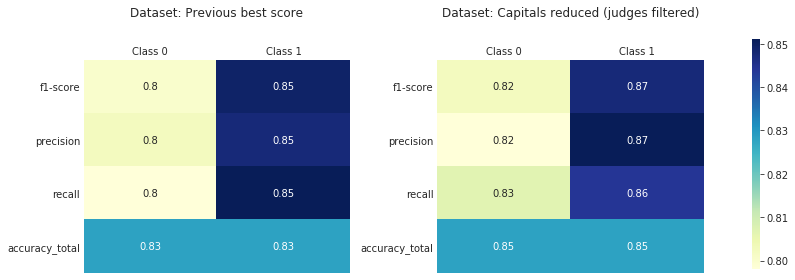

In [304]:
# comparing wit the previous best score

compare_two_scores([iterations_and_scores['Capitals aggr_features, NO n_judges'],
                  iterations_and_scores['Capitals reduced_15']],
                   names=['Previous best score', 'Capitals reduced (judges filtered)'])

In [305]:
# but let's check if it's not caused by just reducing the dataset
# we'll reduce dataset by same size, but this time in random order
# almost no improving, especially on a recall of negative class, which is our more priority class

random_15 = data_with_capitals.sample(8861, random_state=42)

rfc, acc, cr = train_model(random_15[next_features], 'rfc', score=True)

# saving metrics
metrics_df = score_to_frame(cr, acc)
iterations_and_scores['Capitals random_reduced_15'] = metrics_df

0.8341793570219966
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       726
         1.0       0.86      0.86      0.86      1047

   micro avg       0.83      0.83      0.83      1773
   macro avg       0.83      0.83      0.83      1773
weighted avg       0.83      0.83      0.83      1773



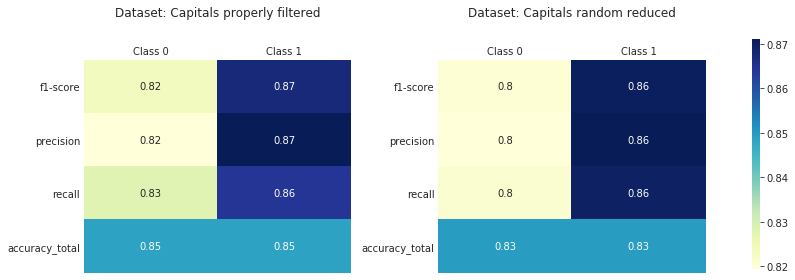

In [307]:
# comparing both visually

compare_two_scores([iterations_and_scores['Capitals reduced_15'],
                  iterations_and_scores['Capitals random_reduced_15']],
                   names=['Capitals properly filtered', 'Capitals random reduced'])

## Reducing with a large dataset

In [313]:
# let's check the same with a larger dataset
# initial score

data_full['judge_average_duration'] = data_full.groupby('judge')['duration_days'].transform('median')

data_full['judge_expected_outcome'] = data_full.groupby('judge')['outcome'].transform('mean')

next_features = [f for f in features_all if f not in ['n_judges', 'claimant_capital', 'defendant_capital']] + \
                                                                    ['judge_average_duration', 'judge_expected_outcome']

rfc, acc, cr = train_model(data_full[next_features], 'rfc', score=True)

# saving metrics
metrics_df = score_to_frame(cr, acc)
iterations_and_scores['full_aggr_features'] = metrics_df

0.782370338310611
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75      6167
         1.0       0.80      0.82      0.81      7696

   micro avg       0.78      0.78      0.78     13863
   macro avg       0.78      0.78      0.78     13863
weighted avg       0.78      0.78      0.78     13863



In [47]:
# size changed just a little bit

grouped = data_full.groupby('judge').size()

more_15 = grouped[grouped > 15].index.tolist()

df_15_all = data_full[data_full.judge.isin(more_15)]

df_15_all.shape

(68698, 32)

In [48]:
# and score even decreased a little

rfc = train_model(df_15_all[next_features], 'rfc')

0.7785298398835516
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.75      6088
         1.0       0.79      0.81      0.80      7652

   micro avg       0.78      0.78      0.78     13740
   macro avg       0.78      0.77      0.77     13740
weighted avg       0.78      0.78      0.78     13740



In [314]:
# we have a much larger dataset now, so can try to be more restrictive and set the treshold by 100
# and it's get higher by a bit
# so the general pattern is less visible, but still holds - reducing dataset size improving the score (hoping not only because of overfit)

grouped = data_full.groupby('judge').size()

more_100 = grouped[grouped > 100].index.tolist()

df_100_all = data_full[data_full.judge.isin(more_100)]

print(f'Dataset size: {df_100_all.shape}')
print('Accuracy score:')

rfc, acc, cr = train_model(df_100_all[next_features], 'rfc', score=True)

# saving metrics
metrics_df = score_to_frame(cr, acc)
iterations_and_scores['full_filtered_100'] = metrics_df

Dataset size: (49381, 32)
Accuracy score:
0.7839424926597145
              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75      4350
         1.0       0.80      0.82      0.81      5527

   micro avg       0.78      0.78      0.78      9877
   macro avg       0.78      0.78      0.78      9877
weighted avg       0.78      0.78      0.78      9877



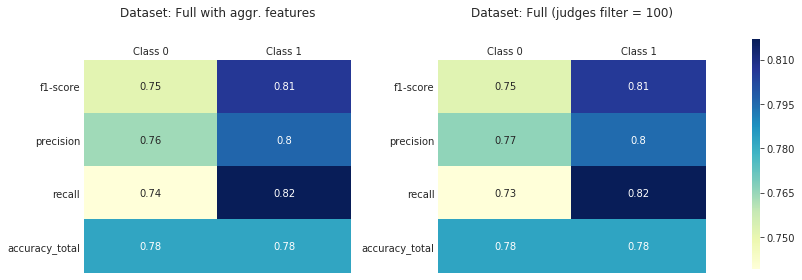

In [315]:
# comparing both visually

compare_two_scores([iterations_and_scores['full_aggr_features'],
                  iterations_and_scores['full_filtered_100']],
                   names=['Full with aggr. features', 'Full (judges filter = 100)'])

### So at least on smaller dataset -  the more statistics with our judges we have, the more accurate we are with our aggregated features.

In [317]:
# let's try compare reduced dataset with capitals and larger one
# fit our reduced dataset without capitals features

next_features = [f for f in features_all if f not in ['n_judges']] + \
                                                                    ['judge_average_duration', 'judge_expected_outcome']

rfc, acc, cr = train_model(data_with_capitals[next_features], 'rfc', score=True)

metrics_df = score_to_frame(cr, acc)
iterations_and_scores['capitals_without_capitals'] = metrics_df

0.816267942583732
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79       901
         1.0       0.84      0.84      0.84      1189

   micro avg       0.82      0.82      0.82      2090
   macro avg       0.81      0.81      0.81      2090
weighted avg       0.82      0.82      0.82      2090



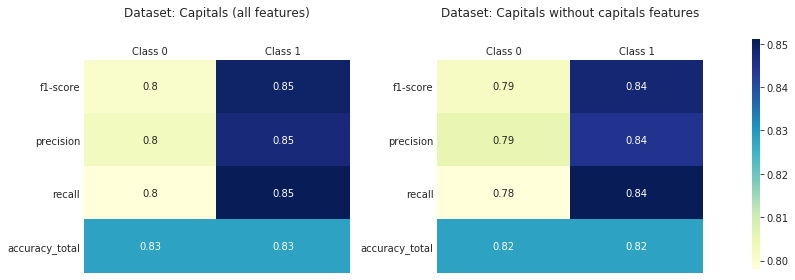

In [319]:
# visual comparison of normal capitals dataset (all features included) and the same without capitals features

compare_two_scores([iterations_and_scores['Capitals aggr_features, NO n_judges'],
                  iterations_and_scores['capitals_without_capitals']],
                   names=['Capitals (all features)', 'Capitals without capitals features'])

## MORE FEATURES

In [118]:
# let's try to get some more features to our dataset
# Do each judge have some favorable day, where approval rate is higher?
# let's pick 5 largest by case counts

judges_largest = data_full.groupby('judge').size().nlargest(5).index.tolist()

judges_largest_df = data_full[data_full.judge.isin(judges_largest)]

judges_largest_df.dayofweek.replace(6, np.nan, inplace=True)
judges_largest_df.dropna(subset=['dayofweek'], inplace=True)

# reaplacing real names with placeholder values
mapping_names = dict(zip(judges_largest_df.judge.unique(), 
                         ['Judge #'+ str(i+1) for i in range(5)]))
judges_largest_df['judge'] = judges_largest_df.judge.map(mapping_names)

table = pd.crosstab(judges_largest_df.dayofweek, judges_largest_df.judge)

def sort_crosstab(table):
    # sorting days of week
    sorter = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    sorterIndex = dict(zip(range(len(sorter)), sorter))
    table.index = table.index.map(sorterIndex)

    return table


sort_crosstab(table)

judge,Judge #1,Judge #2,Judge #3,Judge #4,Judge #5
dayofweek,,,,,
Mon,4,22,223,119,41
Tue,261,13,6,77,24
Wed,5,10,307,128,282
Thu,187,369,14,100,29
Fri,2,29,4,6,28
Sat,0,4,2,0,0


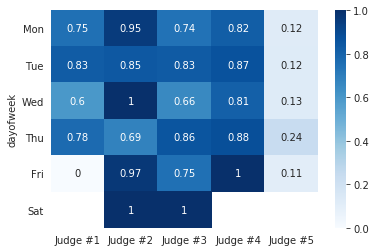

In [126]:
# and here is their outcome rates
# we see that we don't actually need Friday and Saturday
# also we have a problem with days that has less cases, they're confusingly 1 or some pretty numbers like 0.75

mean_table = pd.crosstab(judges_largest_df.dayofweek, judges_largest_df.judge, 
                         values=judges_largest_df.outcome, aggfunc='mean')

sns.heatmap(sort_crosstab(mean_table), annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel(None);

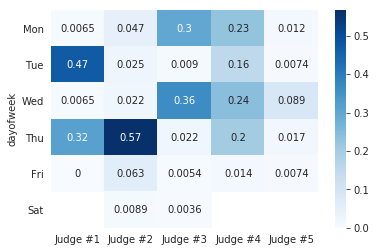

In [128]:
# now we can try to penalize days with small number of cases and have a weighted summary
# actually it's more clear that judges has some schedule than pattern in preferable day when outcome rate is higher

weighted_crosstab = pd.crosstab(judges_largest_df.dayofweek, judges_largest_df.judge, normalize='columns') * \
            pd.crosstab(judges_largest_df.dayofweek, judges_largest_df.judge, values=judges_largest_df.outcome, aggfunc='mean')


sns.heatmap(sort_crosstab(weighted_crosstab), annot=True, cmap='Blues')
plt.yticks(rotation=0);
plt.xlabel(None);

Actually we can still try to use that features, but a lot of variability in number of cases per day makes it very difficult to separate during train/test split. Because if we would not separate, some days of week with a very few cases will be a very big clue to our algorithm. But, if we separate, we would end up with a large number of null vaues. Other features we've already aggregated are not so dependent on one sample, so we are able to aggregate them before we do our train/test split (already checked that by trying both methods - almost no difference)

## Problem with claimant success rate

To illustrate the importance of the train/test split for some features and show the worst case scenario, let's say we want to add such feature as claimant/defendant success rate. It seems like a good idea, we've already have number of cases that claimant/defendant been involved, so why not to have even more accurate feature reflecting success chance?

In [128]:
# we might end up with feature like this, we compute outcome rate and then penalize it by log of number of cases
# we need logarithm to penalize very high cases when claimant involved in a trial first time

df_15['claimant_success'] = df_15.groupby('claimant_split').outcome.transform('mean') * \
        df_15.groupby('claimant_split').claimant_overall.transform(lambda x: np.log(x + 0.01))

df_15['defendant_success'] = df_15.groupby('defendant_split').outcome.transform('mean') * \
        df_15.groupby('defendant_split').claimant_overall.transform(lambda x: np.log(x + 0.01))

In [133]:
# and we've jumped to 95%
# this just can't be our real score

next_features = [f for f in features_capitals if f != 'n_judges'] + ['judge_average_duration', 
                                                                     'judge_expected_outcome', 
                                                                     'claimant_success', 'defendant_success']
rfc = train_model(df_15[next_features], 'rfc')

0.954878736604625
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       756
         1.0       0.96      0.97      0.96      1017

   micro avg       0.95      0.95      0.95      1773
   macro avg       0.95      0.95      0.95      1773
weighted avg       0.95      0.95      0.95      1773



**What's happend?**

Well, we computed our statistics on the entire dataset and its obvious that some undesirable info leaked to our algorithm before we split dataset to training and test parts. Let's try to figure out.

In [149]:
# let's look closer to the values of claimant that were involved in a trial only once (therefore its their first time)
# this is very illustrative, our model just has two values that allow to cheat and predict classes almost perfectly

df_15.query("claimant_overall == 1")[['claimant_success', 'outcome']].sample(5, random_state=42)

,claimant_success,outcome
7457,0.00995,1.0
9843,0.00000,0.0
8633,0.00000,0.0
9079,0.00000,0.0
2367,0.00995,1.0


In [162]:
# and it's more illustrative if we count "first time" claimants in our dataset
# almost 1/4 of our dataset and with the those who were invloved twice, same situation holds

len(df_15.query("claimant_overall == 1")) / len(df_15)

0.22085543392393636

In [163]:
# so we'd better not to use these features

del df_15['claimant_success']
del df_15['defendant_success']

**Is there any chance to utilize those features?**

In [215]:
# next_features = [f for f in features_all if f not in ['n_judges', 'claimant_capital', 'defendant_capital']] + \
#                                                                     ['judge_average_duration', 'judge_expected_outcome',
#                                                                     'average_per_day']

In [210]:
def compute_features_with_split(data, strategy='random'):
    """
    Function to compute features after splitting dataset to training and test part
        strategy:    specified how to handle missing data:
            - random - replace with random number;
            - drop - just drop null values from a dataset
            - other option is to specify here custom array that contains value to inpute
    """
    
    # preparing dataset
    df_train_test = data.copy()

    df_train_test['judge_average_duration'] = df_train_test.groupby('judge')['duration_days'].transform('median')

    df_train_test['judge_expected_outcome'] = df_train_test.groupby('judge')['outcome'].transform('mean')

    df_train = df_train_test.sample(frac=0.8, random_state=42)
    df_test = df_train_test[~(df_train_test.index.isin(df_train.index))]

    assert df_test.shape[0] + df_train.shape[0] == df_train_test.shape[0]
    
    # computing our features only on a training set
    df_train['claimant_success'] = df_train.groupby('claimant_split').outcome.transform('mean') * \
            df_train.groupby('claimant_split').claimant_overall.transform(lambda x: np.log(x + 0.01))

    df_train['defendant_success'] = df_train.groupby('defendant_split').outcome.transform('mean') * \
            df_train.groupby('defendant_split').claimant_overall.transform(lambda x: np.log(x + 0.01))
    
    # merging our training features with test dataset
    rand = np.random.RandomState(42)

    df_test = pd.merge(df_train[['claimant_split', 'claimant_success']].drop_duplicates(subset=['claimant_split']), 
                                          df_test, on='claimant_split', how='inner')

    df_test = pd.merge(df_train[['defendant_split', 'defendant_success']].drop_duplicates(subset=['defendant_split']), 
                                          df_test, on='defendant_split', how='right')
    
    # checking null values
    if df_test[['defendant_success', 'claimant_success']].isnull().any().any():
        # applying strategies
        if strategy == 'random':
            
            df_test['defendant_success'] = df_test['defendant_success'].fillna(rand.rand())
            df_test['claimant_success'] = df_test['claimant_success'].fillna(rand.rand())
        elif strategy == 'drop':
            
            df_test.dropna(subset=['defendant_success', 'claimant_success'], inplace=True)
        else:
            strategy = strategy.replace('data', 'df_test')
#             pass
            df_test['defendant_success'] = df_test['defendant_success'].fillna(eval(strategy))

    next_features = ['outcome', 'n_claimants', 'n_defendants', 'claimant_as_claimant', 'claimant_as_defendant', 
                     'claimant_overall', 'defendant_as_claimant', 'defendant_as_defendant', 'defendant_overall', 
                     'dayofweek', 'duration_days', 'judge_average_duration', 'judge_expected_outcome',
                    'claimant_success', 'defendant_success']
        
    X_train, X_test, y_train, y_test = df_train[next_features].drop('outcome', axis=1), df_test[next_features].drop('outcome', axis=1),\
                                                                    df_train['outcome'], df_test['outcome']
    
    return (X_train, X_test, y_train, y_test)

In [177]:
data_sep_features = compute_features_with_split(df_15)

In [322]:
# and we see how score decreased with a random number, also note precision/recall strange behaviour

rfc = train_model(data_sep_features, data_splitted=True)

0.7668659265584971
              precision    recall  f1-score   support

         0.0       0.67      0.89      0.76       489
         1.0       0.89      0.68      0.77       682

   micro avg       0.77      0.77      0.77      1171
   macro avg       0.78      0.78      0.77      1171
weighted avg       0.80      0.77      0.77      1171



In [328]:
# but what if we would like to just drop the values from a test set for those we didn't find features in training set
# those are samples that we meet the first time in a test set, so we didn't know their success chance
# some strange behaviour is presented, but see how increased recall on negative class

data_sep_features = compute_features_with_split(df_15, strategy='drop')

rfc, acc, cr = train_model(data_sep_features, data_splitted=True, score=True)

# saving metrics
metrics_df = score_to_frame(cr, acc)
iterations_and_scores['capitals_success_rate_drop_strat'] = metrics_df

0.8523002421307506
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84       361
         1.0       0.90      0.83      0.86       465

   micro avg       0.85      0.85      0.85       826
   macro avg       0.85      0.86      0.85       826
weighted avg       0.86      0.85      0.85       826



### Some conclusion we might have: the more we know about company, the better prediction for it we can have.

In [331]:
# and on a large dataset with drop strategy, we increased recall on negative, but decreased in almost everything else
# however overall f1 score increased

df_100_all.dropna(subset=['defendant_split', 'claimant_split'], inplace=True)

data_sep_features = compute_features_with_split(df_100_all, strategy='drop')

rfc, acc, cr = train_model(data_sep_features, data_splitted=True, score=True)

# saving metrics
metrics_df = score_to_frame(cr, acc)
iterations_and_scores['full_success_rate_drop_strat'] = metrics_df

0.8004012036108324
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      1788
         1.0       0.86      0.76      0.81      2200

   micro avg       0.80      0.80      0.80      3988
   macro avg       0.80      0.80      0.80      3988
weighted avg       0.81      0.80      0.80      3988



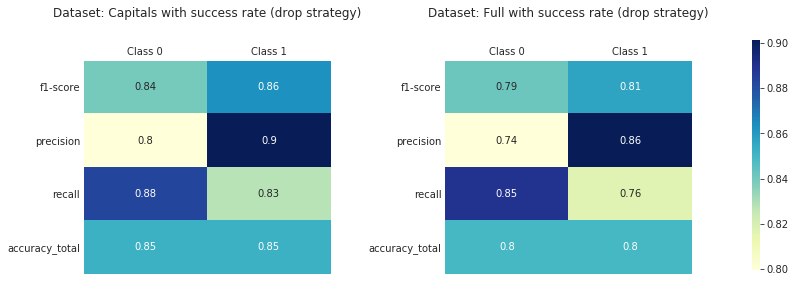

In [332]:
compare_two_scores([iterations_and_scores['capitals_success_rate_drop_strat'],
                  iterations_and_scores['full_success_rate_drop_strat']],
                   names=['Capitals with success rate (drop strategy)', 'Full with success rate (drop strategy)'])

In [333]:
# let's try log feature for judge average - the same performance

df_15['judge_n_cases'] = df_15.groupby('judge').outcome.transform('count')

df_15['judge_rate_log'] = df_15.groupby('judge').outcome.transform('mean') * \
        df_15.judge_n_cases.apply(lambda x: np.log(x))

next_features = ['outcome', 'n_claimants', 'claimant_capital', 'defendant_capital', 'n_defendants', 'claimant_as_claimant', 
                 'claimant_as_defendant', 'claimant_overall', 'defendant_as_claimant', 
                 'defendant_as_defendant', 'defendant_overall', 
                 'dayofweek', 'duration_days', 'judge_average_duration', 'judge_rate_log']

rfc = train_model(df_15[next_features], 'rfc')

0.8482797518330514
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82       756
         1.0       0.87      0.86      0.87      1017

   micro avg       0.85      0.85      0.85      1773
   macro avg       0.84      0.85      0.85      1773
weighted avg       0.85      0.85      0.85      1773



In [354]:
# but on larger dataset almost no imrovement

data_full['judge_n_cases'] = data_full.groupby('judge').outcome.transform('count')

data_full['judge_rate_log'] = data_full.groupby('judge').outcome.transform('mean') * \
        data_full.judge_n_cases.apply(lambda x: np.log(x))

next_features = ['outcome', 'n_claimants', 'n_defendants', 'claimant_as_claimant', 'claimant_as_defendant', 
                 'claimant_overall', 'defendant_as_claimant', 'defendant_as_defendant', 'defendant_overall', 
                 'dayofweek', 'duration_days', 'judge_average_duration', 'judge_rate_log']

rfc = train_model(data_full[next_features], 'rfc')

0.7827310106037654
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75      6167
         1.0       0.80      0.82      0.81      7696

   micro avg       0.78      0.78      0.78     13863
   macro avg       0.78      0.78      0.78     13863
weighted avg       0.78      0.78      0.78     13863



In [ ]:
# what is interesting is that a lot of trials for a company doesn't guarantee high success rate

df_15['individual_rates'] = df_15.groupby('claimant_split').outcome.transform('mean')

selected_rates_df = df_15[(df_15.individual_rates != 0) & (df_15.individual_rates != 1)].copy()

with sns.color_palette('viridis', n_colors=2):
    plt.figure(figsize=(10, 5))
    sns.scatterplot('claimant_overall', 'individual_rates', data=selected_rates_df);

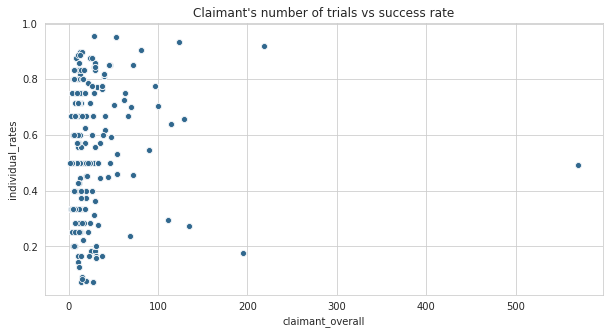

In [335]:
# what is interesting is that a lot of trials for a company doesn't guarantee high success rate

df_15['individual_rates'] = df_15.groupby('claimant_split').outcome.transform('mean')

selected_rates_df = df_15[(df_15.individual_rates != 0) & (df_15.individual_rates != 1)].copy()

with sns.color_palette('viridis', n_colors=2):
    plt.figure(figsize=(10, 5))
    sns.scatterplot('claimant_overall', 'individual_rates', data=selected_rates_df);
    plt.title("Claimant's number of trials vs success rate");

## Do we really need to pick our features manually all the time? Now it's time for some feature selection techniques.

In [336]:
# new function to display what we need

def f_importance_df(data, model):

    return pd.DataFrame([(f, val) for f, val in zip(data.columns[1:], model.feature_importances_.round(3))], 
             columns=['feature', 'importance']).sort_values('importance', ascending=False)

In [337]:
# let's get back to our dataset without timing (recall it's just reducing the size of our dataset)

df_15['judge_average_duration'] = df_15.groupby('judge')['duration_days'].transform('median')

df_15['judge_expected_outcome'] = df_15.groupby('judge')['outcome'].transform('mean')

next_features = [f for f in features_capitals if f != 'n_judges'] + ['judge_average_duration', 
                                                                     'judge_rate_log']
rfc = train_model(df_15[next_features], 'rfc')

0.8448956570783982
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       756
         1.0       0.87      0.86      0.86      1017

   micro avg       0.84      0.84      0.84      1773
   macro avg       0.84      0.84      0.84      1773
weighted avg       0.85      0.84      0.85      1773



### Interesting thing that we're not really using the n_judges features, so model can't just separate instances and guess the proportion. This means that we have a balanced classes with 50/50 approval/refusal and our model perform much better than just guessing. In previous cases our model needed to outperform initial proportion (in first instance it was 80% for example).

In [339]:
# there are a lot of different techniques, but we want to try the one we've already have in our RFC
# as wee see the biggest impact has judge_expected outcome feature, 43% 
# other features are also no surprises

importance_df = f_importance_df(df_15[next_features], rfc)

importance_df.head()

,feature,importance
13,judge_rate_log,0.419
11,duration_days,0.122
3,defendant_capital,0.093
12,judge_average_duration,0.082
2,claimant_capital,0.071


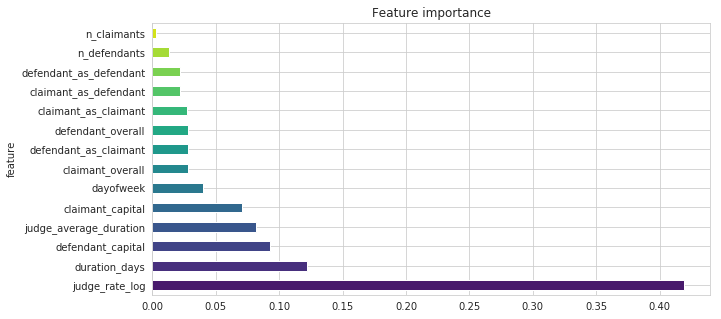

In [345]:
with sns.color_palette('viridis', n_colors=14):
    importance_df.plot.barh('feature', 'importance', figsize=(10, 5), legend=None);
    plt.title('Feature importance')

In [327]:
# let's try some other techniques

rfc = RandomForestClassifier(150, random_state=42)

X = df_15[next_features].drop('outcome', axis=1)
y = df_15['outcome']

scaler = StandardScaler()
X = scaler.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = train_model(df_15[next_features], 'rfc')

0.8448956570783982
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       756
         1.0       0.87      0.86      0.86      1017

   micro avg       0.84      0.84      0.84      1773
   macro avg       0.84      0.84      0.84      1773
weighted avg       0.85      0.84      0.85      1773



In [328]:
# almsot similar behaviour

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=list(df_15[next_features].columns[1:]))

Weight,Feature
0.2787 ± 0.0168,judge_rate_log
0.0261 ± 0.0048,duration_days
0.0188 ± 0.0077,defendant_capital
0.0150 ± 0.0047,n_defendants
0.0097 ± 0.0024,claimant_capital
0.0050 ± 0.0037,judge_average_duration
0.0036 ± 0.0056,defendant_as_claimant
0.0035 ± 0.0055,defendant_overall
0.0032 ± 0.0040,dayofweek
0.0025 ± 0.0034,claimant_overall


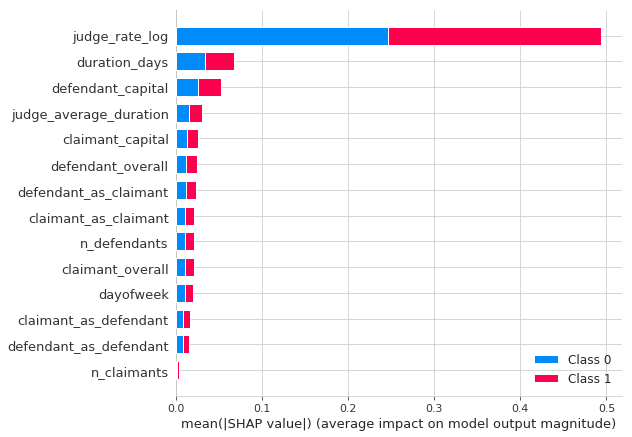

In [329]:
import shap
shap.initjs()

test_data_to_viz = pd.DataFrame(X_test, columns=df_15[next_features].columns[1:])

explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(test_data_to_viz)


shap.summary_plot(shap_values, test_data_to_viz, plot_type='bar')

## Adding category expected rate

In [232]:
# but actually  we're reducing our dataset_size by 15665, so it has only 53650 entries

df_full_categories = data_full.dropna(subset=['category_code'])

df_full_categories['judge_average_duration'] = df_full_categories.groupby('judge')['duration_days'].transform('median')

df_full_categories['judge_expected_outcome'] = df_full_categories.groupby('judge')['outcome'].transform('mean')

df_full_categories['category_exp_rate'] = df_full_categories.groupby('category_code').outcome.transform('mean')

features_to_train = [f for f in next_features if f not in ['claimant_capital', 
                                                           'defendant_capital']] + ['category_exp_rate']

# improvement on each metric

rfc = train_model(df_full_categories[features_to_train], 'rfc')

0.7976700838769805
              precision    recall  f1-score   support

         0.0       0.77      0.76      0.77      4710
         1.0       0.82      0.83      0.82      6020

   micro avg       0.80      0.80      0.80     10730
   macro avg       0.79      0.79      0.79     10730
weighted avg       0.80      0.80      0.80     10730



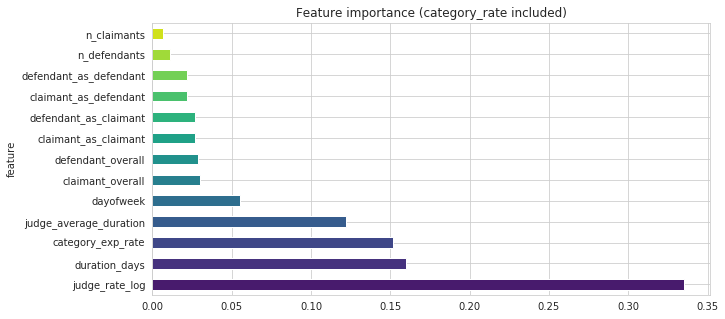

In [358]:
# category expected rate is on a 3rd position

importance_df = f_importance_df(df_full_categories[features_to_train], rfc)

with sns.color_palette('viridis', n_colors=13):
    importance_df.plot.barh('feature', 'importance', figsize=(10, 5), legend=None);
    plt.title('Feature importance (category_rate included)');

# Some extra data analysis

In [367]:
categories = pd.read_csv('2019/cause_categories.csv', '\t')

da_all = pd.merge(data_full, categories).rename({'name': 'categories_name'}, axis=1)

In [133]:
# we've already seen difference in overall outcome rate for first instance and appeal
# now let's explore difference in outcome rate in both depending on different categories

first_sizes = da_all[da_all.instance == 'Перша'].groupby('categories_name').size()[
    da_all[da_all.instance == 'Перша'].groupby('categories_name').size() > 10].to_frame('size')

first_list = first_sizes.index.tolist()

appeal_sizes = da_all[da_all.instance == 'Апеляційна'].groupby('categories_name').size()[
    da_all[da_all.instance == 'Апеляційна'].groupby('categories_name').size() > 10].to_frame('size')

appeal_list = appeal_sizes.index.tolist()


first_categories = da_all[da_all.instance == 'Перша'][
    da_all.categories_name.isin(first_list)].groupby('categories_name').outcome.mean().to_frame()
first_categories = first_categories.join(first_sizes)

appeal_categories = da_all[da_all.instance == 'Апеляційна'][
    da_all.categories_name.isin(appeal_list)].groupby('categories_name').outcome.mean().to_frame()

appeal_categories = appeal_categories.join(appeal_sizes)

first_appeal_categories = pd.merge(first_categories, appeal_categories, right_index=True, left_index=True,
                                  suffixes=['_first', '_appeal'])

In [134]:
# especially we're interested in cases where, appeal outcome rate is higher than in first instance
# this is unusual, and we have 6 such categories

((first_appeal_categories.outcome_appeal - first_appeal_categories.outcome_first) > 0).sum()

3

In [135]:
# only 3 such categories and the most interesting statistics is in bancrupcy cases

first_appeal_categories[((first_appeal_categories.outcome_appeal - first_appeal_categories.outcome_first) > 0)]

,outcome_first,size_first,outcome_appeal,size_appeal
categories_name,,,,
Інша зовнішньоекономічна діяльність,0.666667,93,0.800000,15
Банкрутство,0.062222,450,0.224036,674
лізингу,0.214286,14,0.272727,11


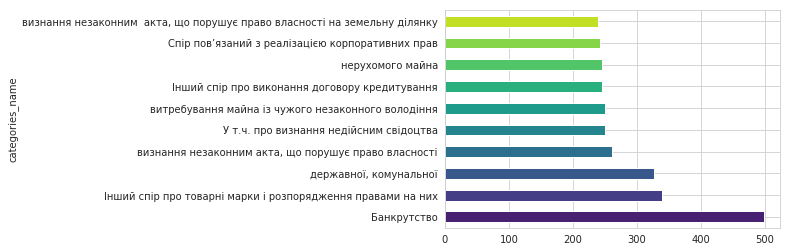

In [141]:
# top 10 with longest duration averages in a first instance

size_25_first = da_all[da_all.instance == 'Перша'].groupby('categories_name').size()[
    da_all[da_all.instance == 'Перша'].groupby('categories_name').size() > 25].index.tolist()

with sns.color_palette('viridis', n_colors=10):
    da_all[da_all.categories_name.isin(size_25_first)].groupby('categories_name').duration_days.mean().nlargest(10).plot.barh();

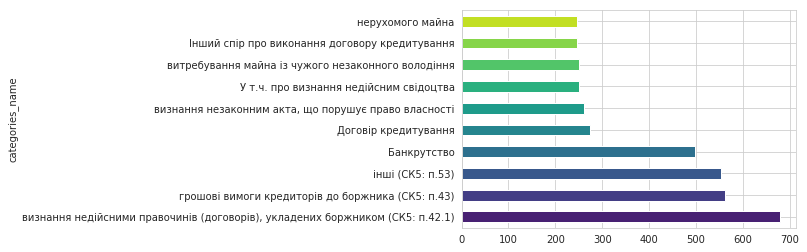

In [140]:
# same for appelation

size_25_appeal = da_all[da_all.instance == 'Апеляційна'].groupby('categories_name').size()[
    da_all[da_all.instance == 'Апеляційна'].groupby('categories_name').size() > 25].index.tolist()

with sns.color_palette('viridis', n_colors=10):
    da_all[da_all.categories_name.isin(size_25_appeal)].groupby('categories_name').duration_days.mean().nlargest(10).plot.barh();

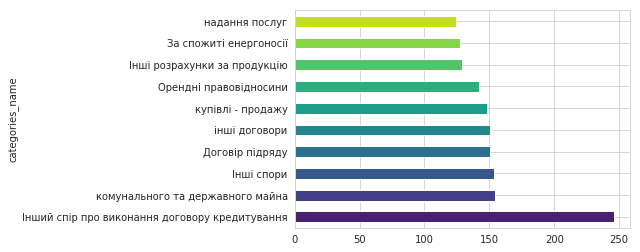

In [142]:
# top 10 by counts

largest_presented = da_all.groupby('categories_name').size().nlargest(10).index.tolist()

with sns.color_palette('viridis', n_colors=10):
    da_all[da_all.categories_name.isin(largest_presented)].groupby('categories_name').duration_days.mean().nlargest(10).plot.barh();

## Outcome rate by sex in different cases categories

In [368]:
from data_extraction_functions import get_judge_sex

filtered_all = da_all.dropna(subset=['sex'])

filtered_all['judges_names'] = filtered_all.judges_names.apply(ast.literal_eval)

filtered_all = filtered_all[~filtered_all['sex'].isin(['[null]'])]

filtered_all['sex'] = filtered_all.sex.apply(lambda x: x.replace('null', '"null"')).apply(ast.literal_eval)

filtered_all['bin_sex'] = filtered_all.apply(get_judge_sex, axis=1)

filtered_all.dropna(subset=['bin_sex'], inplace=True)

filtered_all.shape

(36503, 36)

In [164]:
filtering = filtered_all.groupby(['categories_name', 'bin_sex']).size().unstack()

filtered_names = filtering[(filtering > 30).all(1)].index.tolist()

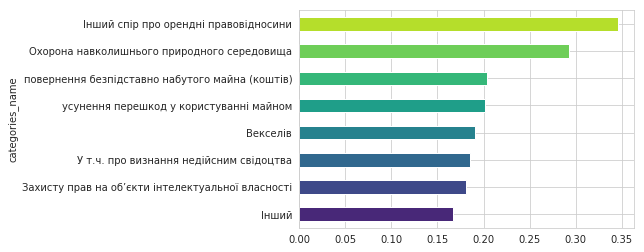

In [165]:
# rates differs in more than 15% in favor of Female

sex_outcomes_diff = filtered_all[filtered_all.categories_name.isin(filtered_names)].groupby(['categories_name', 
                                    'bin_sex']).outcome.mean().unstack().rename({0: 'M', 1: 'F'}, axis=1).eval("F - M")

with sns.color_palette('viridis', n_colors=8):

    sex_outcomes_diff[sex_outcomes_diff > 0.15].sort_values().plot.barh();

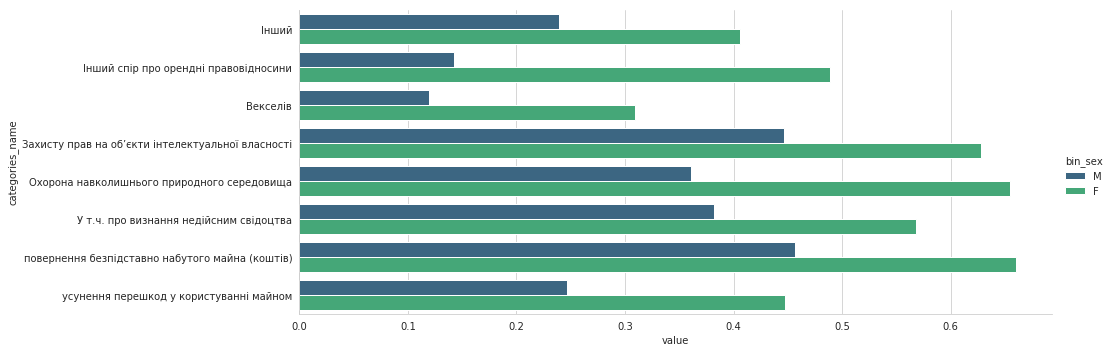

In [166]:
# let's look more close to differences

choice = sex_outcomes_diff[sex_outcomes_diff > 0.15].index.tolist()

unstacked = filtered_all[filtered_all.categories_name.isin(filtered_names)].groupby(['categories_name', 
                                    'bin_sex']).outcome.mean().unstack().rename({0: 'M', 1: 'F'}, axis=1).reset_index()

melted = pd.melt(unstacked, 'categories_name')

sns.catplot('value', 'categories_name', hue='bin_sex', data=melted[melted.categories_name.isin(choice)], 
            kind='bar', orient='h', aspect=3, palette='viridis');

In [6]:
judges_features = pd.read_csv('judges_features.csv')
all_with_dec = pd.merge(filtered_all, judges_features, left_on='judge', right_on='judges')

courts = pd.read_csv('2019/courts.csv', '\t')[['court_code', 'name']].rename({'name': 'court_name'}, axis=1)
all_with_dec = pd.merge(courts, all_with_dec)

In [208]:
top_5_mean = all_with_dec[all_with_dec.court_name.isin(top5_by_assets)]\
                                                .groupby('court_name')['assets.total'].mean().mean()

In [212]:
others_mean = all_with_dec[~all_with_dec.court_name.isin(top5_by_assets)]\
                                                    .groupby('court_name')['assets.total'].mean().mean()

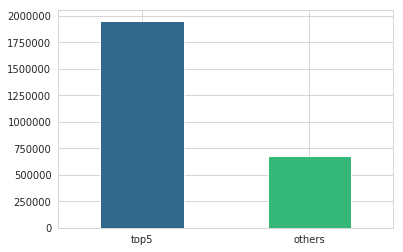

In [221]:
with sns.color_palette('viridis', n_colors=2):

    pd.Series([top_5_mean, others_mean], index=['top5', 'others']).plot.bar();
    plt.xticks(rotation=0)

In [226]:
from sklearn.preprocessing import scale

categories_means = all_with_dec.groupby('categories_name')['assets.total'].mean().to_frame('mean_assets')

categories_means['scaled_means'] = scale(categories_means.mean_assets)
categories_means['counts'] = all_with_dec.groupby('categories_name').size().values
categories_means['mean'] = categories_means.mean_assets.mean()
categories_means['difference_in_mean'] = categories_means.mean_assets - categories_means['mean']

In [370]:
from sklearn.preprocessing import scale

categories_means = all_with_dec.groupby('categories_name')['assets.total'].mean().to_frame('mean_assets')

categories_means['scaled_means'] = scale(categories_means.mean_assets)
categories_means['counts'] = all_with_dec.groupby('categories_name').size().values
categories_means['mean'] = categories_means.mean_assets.mean()
categories_means['difference_in_mean'] = categories_means.mean_assets - categories_means['mean']

In [372]:
categories_means[(categories_means.scaled_means > 0.5) & (categories_means.counts > 50)]

,mean_assets,scaled_means,counts,mean,difference_in_mean
categories_name,,,,,
Інший,2.501074e+06,1.156959,161,1.490319e+06,1.010755e+06
Інший спір про відшкодування шкоди,2.268460e+06,0.890697,1143,1.490319e+06,7.781405e+05
"Інші пошкодження, втрати, псування вантажу",2.129130e+06,0.731213,132,1.490319e+06,6.388103e+05
Іпотека і оренда землі,2.201366e+06,0.813899,62,1.490319e+06,7.110471e+05


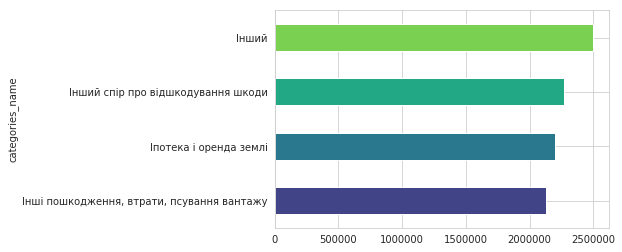

In [373]:
with sns.color_palette('viridis', n_colors=4):

    categories_means[(categories_means.scaled_means > 0.5)
                 & (categories_means.counts > 50)].sort_values('difference_in_mean')['mean_assets'].plot.barh();

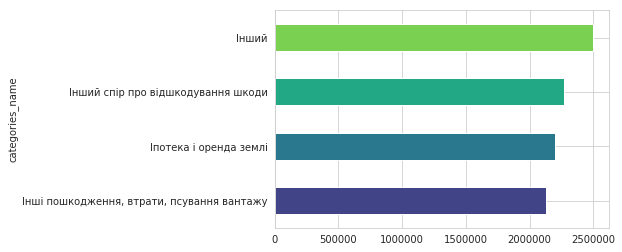

In [266]:
with sns.color_palette('viridis', n_colors=4):

    categories_means[(categories_means.scaled_means > 0.5)
                 & (categories_means.counts > 50)].sort_values('difference_in_mean')['mean_assets'].plot.barh();

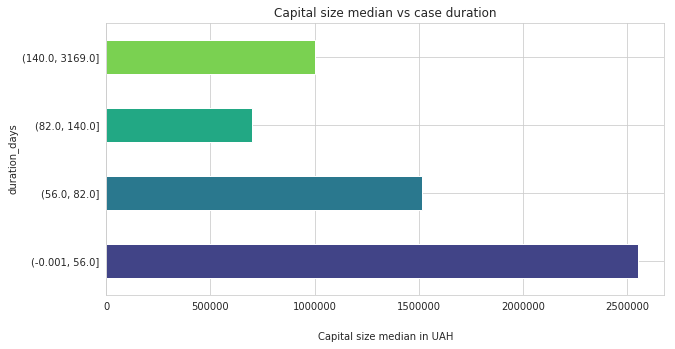

In [364]:
# more capital - faster trial

with sns.color_palette('viridis', n_colors=4):
    plt.figure(figsize=(10, 5))
    data_with_capitals.groupby(pd.qcut(data_with_capitals.duration_days, 4)).claimant_capital.median().plot.barh();
    
    plt.title('Capital size median vs case duration')
    plt.xlabel('Capital size median in UAH', labelpad=20);

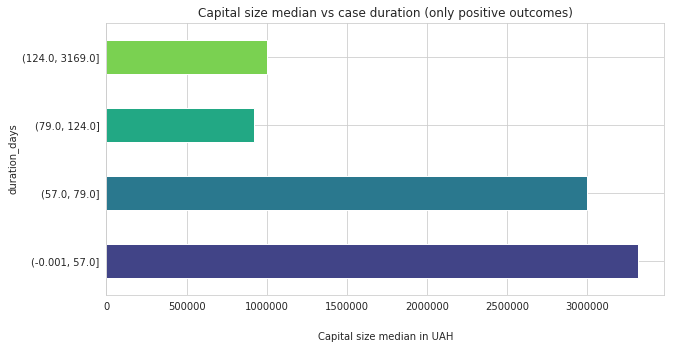

In [365]:
# with approvals even more clear
with sns.color_palette('viridis', n_colors=4):
    plt.figure(figsize=(10, 5))
    approvals = data_with_capitals[data_with_capitals.outcome == 1]

    approvals.groupby(pd.qcut(approvals.duration_days, 4)).claimant_capital.median().plot.barh();
    
    plt.title('Capital size median vs case duration (only positive outcomes)')
    plt.xlabel('Capital size median in UAH', labelpad=20);